# Определение стоимости автомобилей

Требуется построить модель для определения стоимости автомобиля с помощью исторических данных.

Основные критерии модели:

- качество предсказания;
- скорость предсказания;
- время обучения.

Признаки

- *DateCrawled* — дата скачивания анкеты из базы

- *VehicleType* — тип автомобильного кузова

- *RegistrationYear* — год регистрации автомобиля

- *Gearbox* — тип коробки передач

- *Power* — мощность (л. с.)

- *Model* — модель автомобиля

- *Kilometer* — пробег (км)

- *RegistrationMonth* — месяц регистрации автомобиля

- *FuelType* — тип топлива

- *Brand* — марка автомобиля

- *NotRepaired* — была машина в ремонте или нет

- *DateCreated* — дата создания анкеты

- *NumberOfPictures* — количество фотографий автомобиля

- *PostalCode* — почтовый индекс владельца анкеты (пользователя)

- *LastSeen* — дата последней активности пользователя

Целевой признак

- *Price* — цена (евро)

## Подготовка данных

Импортируем библиотеки

In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt
import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

In [4]:
df = pd.read_csv('/datasets/autos.csv')

In [5]:
df.head(10)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04 00:00:00,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06


In [107]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

Посмотрим на долю пропусков данных.

In [108]:
df.isna().mean()

DateCrawled          0.000000
Price                0.000000
VehicleType          0.105794
RegistrationYear     0.000000
Gearbox              0.055967
Power                0.000000
Model                0.055606
Kilometer            0.000000
RegistrationMonth    0.000000
FuelType             0.092827
Brand                0.000000
NotRepaired          0.200791
DateCreated          0.000000
NumberOfPictures     0.000000
PostalCode           0.000000
LastSeen             0.000000
dtype: float64

В данных есть пропуски в категориальных параметрах. Для начала удалим все строки с пропусками в каждом из параметров и нулевым значением мощности.

In [109]:
df = df[~(df['Gearbox'].isna() & df['Model'].isna() & df['FuelType'].isna() & df['VehicleType'].isna() & df['NotRepaired'].isna() & (df['Power'] == 0))]

Теперь оценим распределения количественных признаков.

<AxesSubplot:>

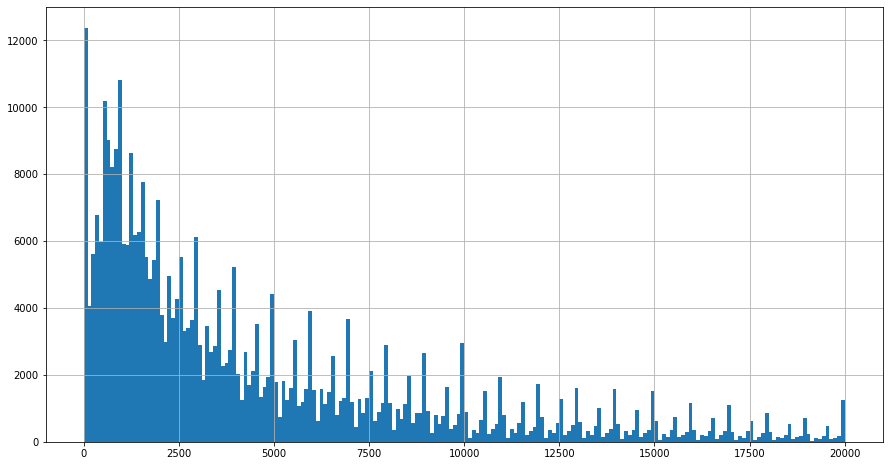

In [110]:
df['Price'].hist(bins=200,figsize=(15,8))

В цене около 13000 нулевых значений. Удалю их т.к. это будет влиять на конечный результат предсказания.

In [111]:
df = df[df['Price'] > 10]

В столбце "год регистрации" сразу отфильтруем и оставим правдоподобные значения выше 1980 и ниже 2022г.

In [112]:
df = df[(df['RegistrationYear'] < 2022) & (df['RegistrationYear'] > 1980)]

Взгляним на распределение параметра.

<AxesSubplot:xlabel='RegistrationYear'>

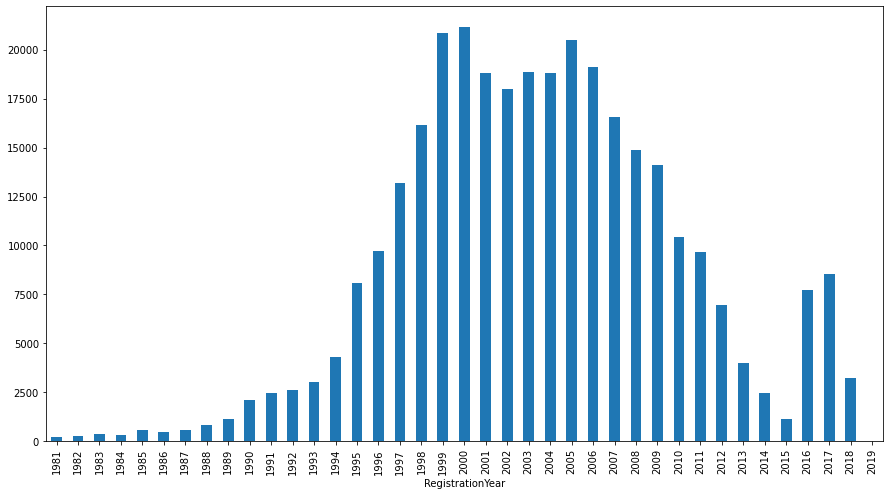

In [113]:
df.groupby('RegistrationYear')['Model'].count().plot.bar(figsize=(15,8))

Выделяются 2016-2018 гг. Чтобы решить данную проблему отфильтруем явно неверные значения, в которых год регистрации автомобиля больше года регистрации анкеты, а если года равны, то также сравним месяцы. Для этого сделаем отдельные колонки года и месяца создания анкеты.

In [114]:
df['year_created'] = pd.to_datetime(df['DateCreated'], format='%Y-%m-%d %H:%M:%S').dt.year
df['month_created'] = pd.to_datetime(df['DateCreated'], format='%Y-%m-%d %H:%M:%S').dt.month

In [115]:
df = df[~(df['year_created'] < df['RegistrationYear'])]
df = df[~((df['year_created'] == df['RegistrationYear']) & (df['month_created'] < df['RegistrationMonth']))]

Посмотрим на результат выполнения фильтра.

<AxesSubplot:xlabel='RegistrationYear'>

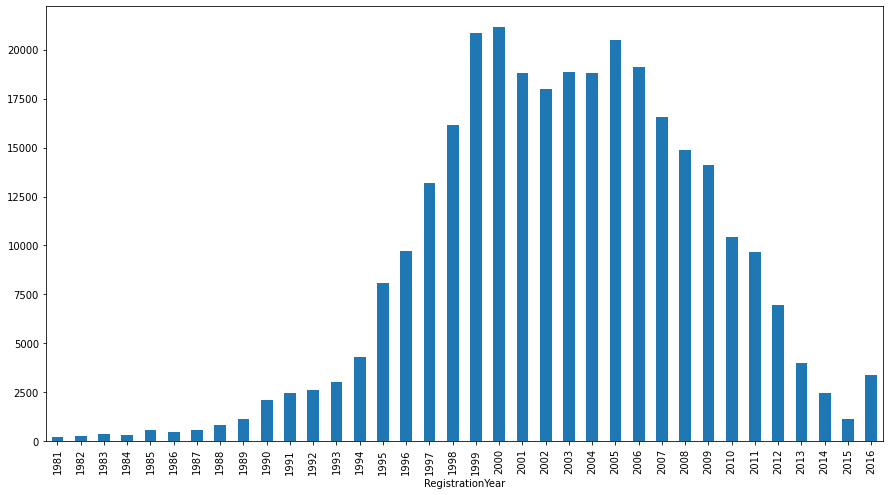

In [116]:
df.groupby('RegistrationYear')['Model'].count().plot.bar(figsize=(15,8))

Посмотрим на распределение мощности.

<AxesSubplot:>

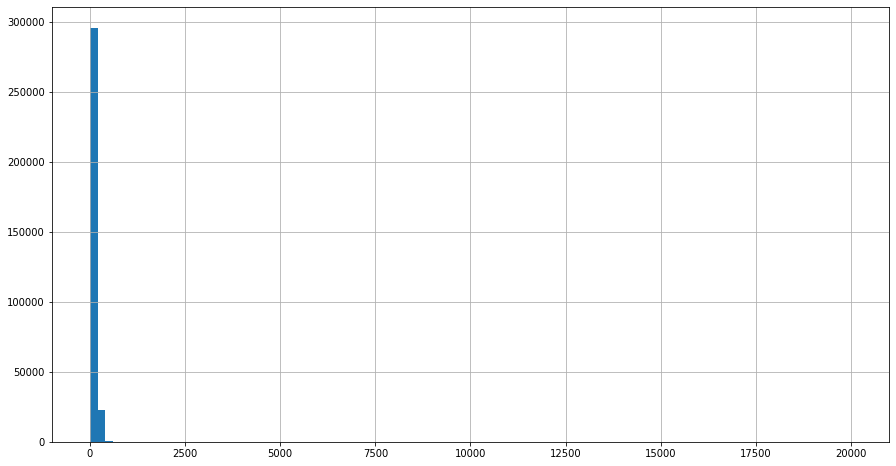

In [117]:
df['Power'].hist(bins=100, figsize=(15,8))

В столбце есть аномалии отсечем их.

In [118]:
df = df[~((df['Power'] > 400) | (df['Power'] < 40))]

<AxesSubplot:>

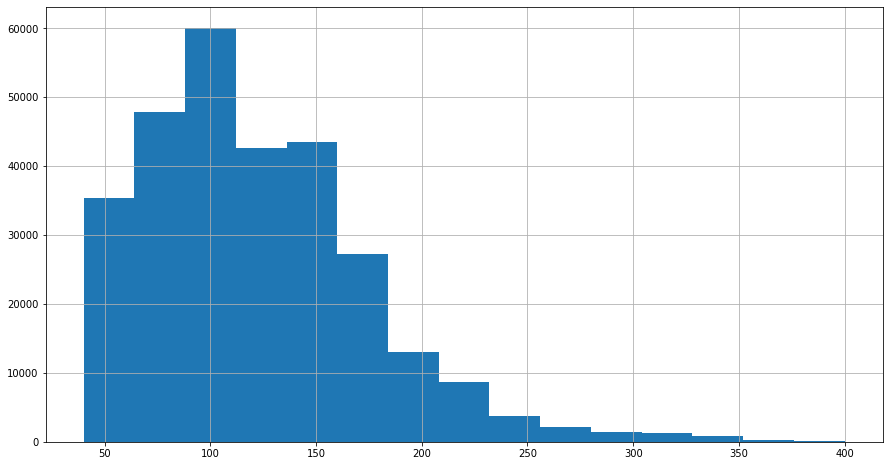

In [119]:
df['Power'].hist(bins=15, figsize=(15,8))

Проанализируем пробег.

In [120]:
df['Kilometer'].describe()

count    288456.000000
mean     128627.728319
std       36388.257991
min        5000.000000
25%      125000.000000
50%      150000.000000
75%      150000.000000
max      150000.000000
Name: Kilometer, dtype: float64

Тут явных аномалий нет, вроде все хорошо.

Посмотрим на столбец с информацией о кол-ве фото.

In [121]:
df['NumberOfPictures'].describe()

count    288456.0
mean          0.0
std           0.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max           0.0
Name: NumberOfPictures, dtype: float64

Нулевой столбец - удалим его.

Теперь проанализируем категориальные переменные. Начнем с VehicleType.

In [122]:
df['VehicleType'].value_counts(normalize=True, dropna=False)

sedan          0.283475
small          0.240092
wagon          0.204302
bus            0.090353
convertible    0.063573
coupe          0.048690
suv            0.037208
NaN            0.024333
other          0.007973
Name: VehicleType, dtype: float64

Чуть больше чем 2.5 % пропусков. Но есть категория other объеденим other и nan.

In [123]:
df['VehicleType'] = df['VehicleType'].fillna('other')

Рассмотрим Gearbox.

In [124]:
df['Gearbox'].value_counts(normalize=True, dropna=False)

manual    0.784116
auto      0.198765
NaN       0.017119
Name: Gearbox, dtype: float64

Тут пропуски переведем в отдельную категорию 'no_data'.

In [125]:
df['Gearbox'] = df['Gearbox'].fillna('no_data')

Посмотрим куда определить пропуски в Model.

In [126]:
df['Model'].unique()

array([nan, 'grand', 'golf', 'fabia', '3er', '2_reihe', 'c_max',
       '3_reihe', 'passat', 'navara', 'polo', 'twingo', 'a_klasse',
       'scirocco', '5er', 'arosa', 'other', 'civic', 'transporter',
       'punto', 'e_klasse', 'kadett', 'one', 'fortwo', 'clio', '1er',
       'b_klasse', 'a8', 'jetta', 'fiesta', 'c_klasse', 'micra', 'vito',
       'sprinter', 'astra', '156', 'escort', 'forester', 'xc_reihe',
       'scenic', 'ka', 'a1', 'focus', 'a4', 'tt', 'a6', 'jazz', 'omega',
       'slk', '7er', 'combo', 'corsa', '80', '147', 'z_reihe', 'sorento',
       'ibiza', 'mustang', 'eos', 'touran', 'getz', 'insignia', 'megane',
       'a3', 'lupo', 'r19', 'caddy', 'mondeo', 'cordoba', 'colt',
       'impreza', 'vectra', 'berlingo', 'tiguan', '6_reihe', 'c4',
       'panda', 'up', 'i_reihe', 'ceed', 'kangoo', '5_reihe', 'yeti',
       'octavia', 'zafira', 'mii', 'rx_reihe', '6er', 'modus', 'fox',
       'matiz', 'beetle', 'rio', 'touareg', 'logan', 'spider', 'cuore',
       's_max', 'a2',

Переведем в other.

In [127]:
df['Model'] = df['Model'].fillna('other')

Проанализируем параметр описывающий тип топлива.

In [128]:
df['FuelType'].value_counts(normalize=True, dropna=False)

petrol      0.632939
gasoline    0.301634
NaN         0.046804
lpg         0.015989
cng         0.001640
hybrid      0.000686
other       0.000184
electric    0.000125
Name: FuelType, dtype: float64

Переведем пропуски в other

In [129]:
df['FuelType'] = df['FuelType'].fillna('other')

Взглянем на бренды. Тут пропусков нет, но возможны повторы или ошибки заполнения.

In [130]:
df['Brand'].value_counts(normalize=True, dropna=False)

volkswagen        0.216355
bmw               0.110201
opel              0.109476
mercedes_benz     0.092184
audi              0.087164
ford              0.069969
renault           0.047182
peugeot           0.032119
fiat              0.025234
seat              0.019837
skoda             0.016945
mazda             0.016113
smart             0.015302
citroen           0.014200
nissan            0.013836
toyota            0.013742
hyundai           0.010684
mini              0.010185
volvo             0.009537
mitsubishi        0.008514
honda             0.008057
kia               0.007148
suzuki            0.006625
alfa_romeo        0.006583
chevrolet         0.004729
sonstige_autos    0.004333
chrysler          0.003935
dacia             0.002742
subaru            0.002201
daihatsu          0.002084
jeep              0.001893
porsche           0.001872
saab              0.001619
land_rover        0.001539
jaguar            0.001449
daewoo            0.001387
lancia            0.001245
r

В столбце NotRepaired есть пропуски. Посмотрим куда их можно классифицировать.

In [131]:
df['NotRepaired'].value_counts(normalize=True, dropna=False)

no     0.762754
NaN    0.140382
yes    0.096864
Name: NotRepaired, dtype: float64

Заведем отдельный тип no_data

In [132]:
df['NotRepaired'] = df['NotRepaired'].fillna('no_data')

Удалим параметры не влияющие на целевой признак.

In [133]:
df = df.drop(['DateCrawled', 'RegistrationMonth', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen',
             'LastSeen', 'year_created', 'month_created'], axis=1)

In [134]:
df.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
1,18300,coupe,2011,manual,190,other,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,no_data
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no
5,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes


In [135]:
df['Price'] = df['Price'].astype('float')

Все категориальные переменные преобразуем для алгоритмов ML с помощью get_dummies.

In [136]:
df = pd.get_dummies(df, ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired'], drop_first=True)

Произведем разделение данных на тренировочную и валидационную.

In [137]:
features = df.drop('Price', axis=1)
target = df['Price']
features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size=0.25, random_state=1337)

In [138]:
print(features_train.shape, features_valid.shape, target_train.shape, target_valid.shape)

(216342, 306) (72114, 306) (216342,) (72114,)


Произведем стандартизацию количественных признаков всех кроме целевого.

In [139]:
scaler = StandardScaler().fit(features_train[['RegistrationYear', 'Power', 'Kilometer']])
features_train[['RegistrationYear', 'Power', 'Kilometer']] = scaler.transform(features_train[['RegistrationYear', 
                                                                                              'Power', 'Kilometer']])
features_valid[['RegistrationYear', 'Power', 'Kilometer']] = scaler.transform(features_valid[['RegistrationYear', 
                                                                                              'Power', 'Kilometer']])

**Вывод**

В ходе анализа таблицы были выявлены пропуски в категориальных данных. Также были замечены аномальные значения в количественных признаках. Все не восстанавливаемые пропуски и аномалии были отфильтрованы. На данном шаге были произведена стандартизация количественных данных и преобразованы категориальные.

## Обучение моделей

### CatBoost

Обучим catboost, найдем подходящие параметры.

In [140]:
parametrs = {
    'iterations': range(12,18,2),
    'depth': range(12,18,2)
}

In [141]:
%%time
model = CatBoostRegressor(loss_function='RMSE', random_state=1337)
grid = GridSearchCV(model, parametrs, cv=2)
grid.fit(features_train, target_train, verbose=False)
grid.best_params_

CPU times: user 2min 54s, sys: 1min 3s, total: 3min 57s
Wall time: 4min 15s


{'depth': 16, 'iterations': 16}

Параметры для catboost: depth=16, iterations=16

### RandomForest

In [142]:
parametrs = {
    'max_depth': range(12,18,2)
}

In [143]:
%%time
model_forest = RandomForestRegressor(n_estimators=100, random_state=1337)
grid = GridSearchCV(model_forest, parametrs, cv=2)
grid.fit(features_train, target_train)
grid.best_params_

CPU times: user 23min 25s, sys: 2.86 s, total: 23min 28s
Wall time: 23min 31s


{'max_depth': 16}

Параметры для randomforest n_estimators=100, max_depth=16

### LGBMRegressor

Найдем подходящие параметры.

In [144]:
parametrs = {
    'n_estimators': range(14,18,2),
    'max_depth': range(14,18,2)
}

In [145]:
%%time
model_lgbm = LGBMRegressor(random_state=1337, learning_rate=0.5)
grid = GridSearchCV(model_lgbm, parametrs, cv=2)
grid.fit(features_train, target_train)
grid.best_params_

CPU times: user 1min 47s, sys: 3.28 s, total: 1min 50s
Wall time: 1min 51s


{'max_depth': 16, 'n_estimators': 16}

Параметры для randomforest n_estimators=16, max_depth=16

## Анализ моделей

Теперь посмотрим сколько времени catboost будет обучаться, предсказывать целевой параметр и замерим rmse.

In [146]:
%%time
model_cat = CatBoostRegressor(loss_function='RMSE', iterations=16, depth=16, random_state=1337)
model_cat.fit(features_train, target_train, verbose=False)

CPU times: user 20.3 s, sys: 8.26 s, total: 28.5 s
Wall time: 29.6 s


In [147]:
%%time
pred = model_cat.predict(features_valid)
rmse = mean_squared_error(pred, target_valid)**0.5
print(rmse)

1584.1084534273577
CPU times: user 59.1 ms, sys: 4.16 ms, total: 63.2 ms
Wall time: 60.9 ms


catboost обучается примерно 20-30 s, предсказывает за 30-50 ms, rmse=1584.11

Text(0.5, 1.0, 'Feature Importance CatBoost')

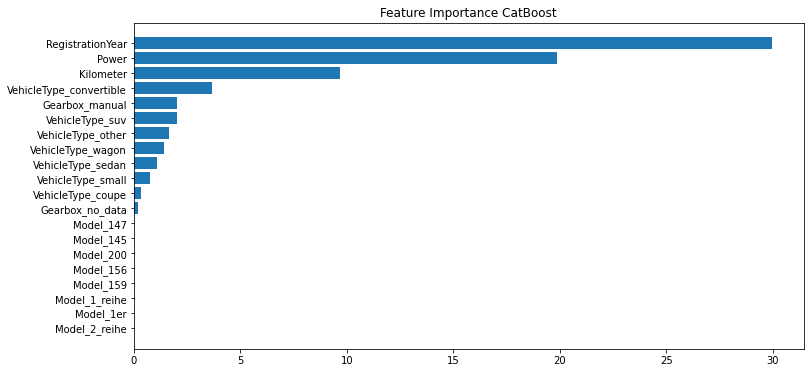

In [148]:
feature_importance = model_cat.feature_importances_[:20]
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(features_train.columns)[sorted_idx])
plt.title('Feature Importance CatBoost')

Оценим работу randomforest.

In [149]:
%%time
model_forest = RandomForestRegressor(n_estimators=14, max_depth=16, random_state=1337)
model_forest.fit(features_train, target_train)

CPU times: user 59.7 s, sys: 255 ms, total: 1min
Wall time: 1min


RandomForestRegressor(max_depth=16, n_estimators=14, random_state=1337)

In [150]:
%%time
pred = model_forest.predict(features_valid)
rmse = mean_squared_error(pred, target_valid)**0.5
print(rmse)

1593.8187421924154
CPU times: user 331 ms, sys: 75.6 ms, total: 407 ms
Wall time: 425 ms


randomforest обучается примерно 50-60 s, предсказывает за ~360 ms, rmse=1593.82

Text(0.5, 1.0, 'Feature Importance RandomForest')

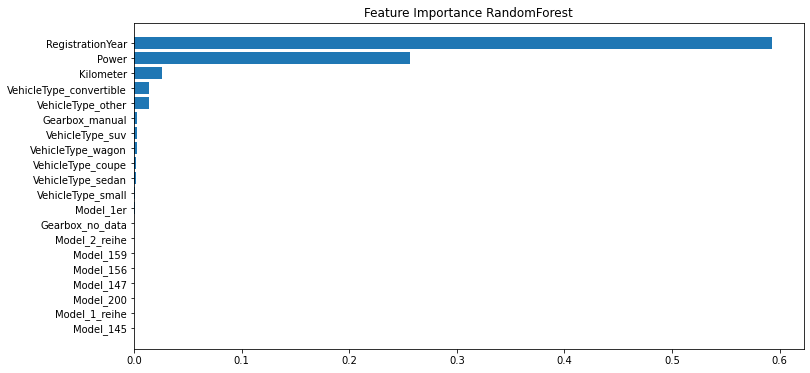

In [151]:
feature_importance = model_forest.feature_importances_[:20]
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(features_train.columns)[sorted_idx])
plt.title('Feature Importance RandomForest')

Посмотрим на метрики LGBMRegressor.

In [152]:
%%time
model_lgbm = LGBMRegressor(n_estimators=16, max_depth=16, random_state=1337, learning_rate=0.5)
model_lgbm.fit(features_train, target_train)

CPU times: user 14.9 s, sys: 366 ms, total: 15.3 s
Wall time: 15.4 s


LGBMRegressor(learning_rate=0.5, max_depth=16, n_estimators=16,
              random_state=1337)

In [153]:
%%time
pred = model_lgbm.predict(features_valid)
rmse = mean_squared_error(pred, target_valid)**0.5
print(rmse)

1675.5992408412844
CPU times: user 387 ms, sys: 95.1 ms, total: 483 ms
Wall time: 500 ms


LGBMRegressor обучается примерно 8-15 s, предсказывает за ~330 ms, rmse=1675.60

Text(0.5, 1.0, 'Feature Importance LGBMRegressor')

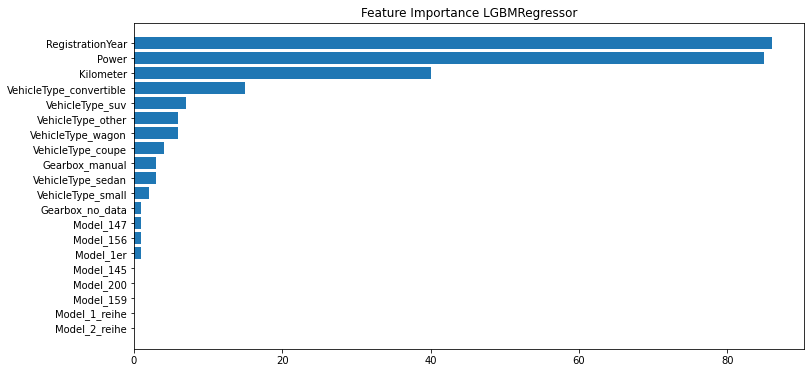

In [154]:
feature_importance = model_lgbm.feature_importances_[:20]
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(features_train.columns)[sorted_idx])
plt.title('Feature Importance LGBMRegressor')

Сведем все данные в таблицу.

In [155]:
result = pd.DataFrame({'Модель': ['CatBoost', 'RandomForest', 'LGBMRegressor'], 'Время обучения (с)':['20-30', '50-60', '8-15'],
                      'Время предсказания (мс)': ['~40', '~360', '~330'], 'rmse': [1584.11, 1593.82, 1675.60]})

In [156]:
result

,Модель,Время обучения (с),Время предсказания (мс),rmse
0,CatBoost,20-30,~40,1584.11
1,RandomForest,50-60,~360,1593.82
2,LGBMRegressor,8-15,~330,1675.60


**Вывод**

Для проекта предсказания цены автомобиля были предоставлены данные, которые имели пропуски и аномалии. Каждый параметр был проанализирован и после чего очищен от явных несоответствий. Категориальные данные были переведены в специальную форму для ML, а количественные были стандартизированы.

Обучение производилось на трех моделях: Catboost, RandomForest и LGBMRegressor. Моделью имеющую самую быструю скорость обучения оказалась LGBMRegressor 8-15 s, потом идет Catboost 20-30 s и RandomForest 50-60 s. Catboost имеет самую высокую скорость предсказания и высокое качество метрики rmse (предсказывает за ~40 ms, rmse=1584.11), LGBMRegressor предсказывает за ~330 ms, rmse=1675.60, а RandomForest предсказывает за ~360 ms, rmse=1593.82. Важными факторами оказались: год выпуска, мощность, пробег и тип кузова.

Исходя из желаний заказчика для работы с этими данными я выбираю CatBoost.